In [21]:
import pandas as pd
import numpy as np
import os
import re
from decimal import *

from numpy.random import seed
from numpy.random import randn,randint
import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt
import plotly.express as px

Run notebook to create list of descriptions for each measurment

In [91]:
%run TAKSIM_sorb.ipynb

129
Point                                    Health index   
я 28.9 после ужина левая.XML             57.1           
я вечер после ужина 28.9 правая.XML      0.0            
я после ужина 28.9 левая 2.XML           100.0          
я после ужина правая 2.XML               57.1           
Point                                    Health index   
ч утро 30.9 правая.XML                   0.0            
я после обеда 30.9 левая 1.XML           100.0          
я после обеда 30.9 левая 2.XML           87.3           
я после обеда правая 1.XML               0.0            
я утро 30.9 левая.XML                    12.7           


In [92]:
len(raw_corpus)

129

## Text processing

In [93]:
# split text into tokens (phrases between slashes)
def process_text(text):
    tokens_list = []
    tokens = text.split('/')
    for token in tokens:
        token = token.strip()
        token = token.lower()
        list_words = token.split()
        list_words = [word.replace(chr(8211), '-') for word in list_words]
        token = ' '.join(list_words)
        if token:
            tokens_list.append(token)                                  
    return tokens_list

In [94]:
# generate corpus - list of lists
# each nested list is a list of tokens
corpus = []
for text_list in raw_corpus:
    processed_text = []
    for text in text_list:
        processed_text.extend(process_text(text))
    corpus.append(processed_text)

In [95]:
corpus[0]

['норма',
 'норма',
 'норма',
 'норма',
 'сильная усталость, требуется отдых',
 'организм расслаблен',
 'торможение после стресса',
 'не хватает воды',
 'стресс',
 'боль',
 'при отсутствии симптомов - контроль давления',
 'требуется отдых, сильное истощение',
 'усталость',
 'слабость',
 'спазм',
 'голод',
 'легкий стресс',
 'расслабление после еды',
 'при повторении - следить за состоянием.']

## Paraphrase Mining

In [96]:
sentences = set()
for doc in corpus:
    sentences = sentences.union(set(doc))

In [97]:
len(sentences)

88

In [98]:
sentences = list(sentences)

In [99]:
from sentence_transformers import SentenceTransformer, util

# Download model
model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')

In [100]:
# Look for paraphrases
paraphrases = util.paraphrase_mining(model, sentences)

In [101]:
len(paraphrases)

3828

In [102]:
# Print paraphrases
result = []
for paraphrase in paraphrases:
    score, i, j = paraphrase
#     if sentences[i] == sentences[j]:
#         continue
#     if any(sentences[i] in (score, sent1, sent2) for (score, sent1, sent2) in result):
#         continue
    if (score, sentences[i], sentences[j]) not in result:
        result.append((score, sentences[i], sentences[j]))
for paraphrase in result:
    if paraphrase[0] < 0.6:
        break
    print("Score {:.4f} ---- {} ---- {}".format(paraphrase[0], paraphrase[1], paraphrase[2]))

Score 0.9767 ---- после еды - норма ---- справа после еды - норма
Score 0.9591 ---- критические дни ---- критические дни (гормоны)
Score 0.9462 ---- голод ---- легкий голод
Score 0.9433 ---- боль ---- спазм, боль
Score 0.9379 ---- требуется отдых, сильное истощение ---- сильная усталость, требуется отдых
Score 0.9367 ---- стресс ---- легкий стресс
Score 0.9241 ---- сильный спазм, боль ---- спазм, боль
Score 0.9198 ---- расслабление после сильных нагрузок ---- расслабление после стресса
Score 0.9178 ---- развитие воспаления! ---- воспаление (см. другие!)
Score 0.9176 ---- испуг, спазм ---- испуг
Score 0.9158 ---- усталость ---- сильная усталость, требуется отдых
Score 0.9089 ---- голод, переутомление ---- справа - легкая усталость, голод
Score 0.9017 ---- усталость ---- слабость, усталость
Score 0.8942 ---- слабость, упадок сил. при повторении - обратить внимание ---- слабость, легкое недомогание; упадок сил
Score 0.8936 ---- натощак - спазм желчных протоков (0,43) (см. другие) ---- есл

In [103]:
paraphrased_corpus = corpus.copy()

In [104]:
replaced = []
replacing = []
for (score, sent1, sent2) in result:
    if score < 0.7:
        break
    if sent2 in replaced:
        continue
    if sent1 in replacing:
        continue
    for i, doc in enumerate(paraphrased_corpus):
        for j, word in enumerate(doc):
            if word == sent1:
                replaced.append(sent1)
                replacing.append(sent2)
                paraphrased_corpus[i][j] = sent2         

## TF-IDF

In [105]:
import collections
import math

In [106]:
# compute tf-idf based on our tokens

def compute_tf(text):
# number of times a word appeared in the text / number of all words in the text
    tf_text = collections.Counter(text)
    for i in tf_text:
        tf_text[i] = tf_text[i]/float(len(text))
    return tf_text

def compute_idf(word, corpus):
# log(number of documents / number of documents where the word occurs)
        return math.log10(len(corpus)/sum([1.0 for i in corpus if word in i]))

In [107]:
# generate list of documents
# each document is represented as a dictionary, where the key is a word and the value is tf-idf value
documents_list = []
for text in paraphrased_corpus:
    tf_idf_dictionary = {}
    computed_tf = compute_tf(text)
    for word in computed_tf:
        tf_idf_dictionary[word] = computed_tf[word] * compute_idf(word, paraphrased_corpus)
    documents_list.append(tf_idf_dictionary)

In [108]:
# number of unique words (tokens)
dictionary = set()
for text in paraphrased_corpus:
    for word in text:
        dictionary.add(word)

In [109]:
len(dictionary)

45

In [110]:
# create matrix m*n
# m = number of documents
# n = number of words (tokens)
custom_tfidf_df = pd.DataFrame(index=np.arange(len(corpus)), columns=sorted(dictionary)).fillna(0)

In [111]:
for i in range(len(documents_list)):
    for k, v in documents_list[i].items():
        custom_tfidf_df.loc[i, k] = v

In [112]:
custom_tfidf_df.head()

,out of intervals,"в жаре, влажные ладони - норма","волнение, напряжение, спазм",воспаление (см. другие!),"если натощак - спазм желчных протоков (0,96-1,1)",жарко,"замедленная реакция нс, торможение, легкое недомогание, простуда, ослабление организма",испуг,контроль температуры,критические дни (гормоны),...,системная усталость,"слабость, легкое недомогание; упадок сил","спазм сосудов, артерии - гипоксия!","спазм сосудов, боль (меньше 0,98)","спазм, боль","справа - легкая усталость, голод",справа после еды - норма,"у пожилых, очень сухая кожа - норма",угнетение после стресса,часто у курильщиков
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.013014,0.000000,0.000000,0.000000,0.000000,0.0
1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.012363,0.000000,0.000000,0.022869,0.000000,0.0
2,0.0,0.000000,0.000000,0.000000,0.012684,0.016096,0.0,0.0,0.012127,0.000000,...,0.0,0.000000,0.0,0.016441,0.010303,0.000000,0.000000,0.000000,0.000000,0.0
3,0.0,0.011062,0.000000,0.000000,0.012684,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.027703,0.0,0.000000,0.000000,0.017151,0.010303,0.000000,0.033732,0.0
4,0.0,0.000000,0.019601,0.019191,0.000000,0.000000,0.0,0.0,0.000000,0.021325,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [113]:
custom_tfidf = custom_tfidf_df.values
custom_tfidf.shape

(129, 45)

## Clustering

In [88]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [58]:
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(custom_tfidf)
    Sum_of_squared_distances.append(km.inertia_)

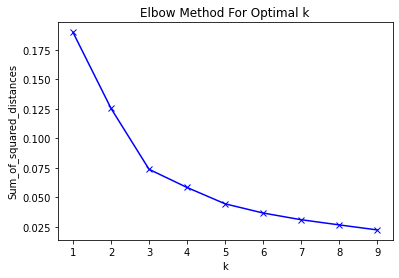

In [59]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [89]:
num_clusters = 3

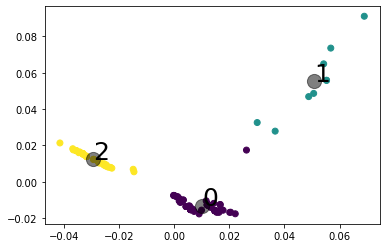

In [403]:
kmeans = KMeans(n_clusters=num_clusters).fit(custom_tfidf)
y_kmeans = kmeans.predict(custom_tfidf)

pca = PCA(n_components=2)
reduced = pca.fit_transform(custom_tfidf)

t = reduced.transpose()

centers = kmeans.cluster_centers_
reduced_centers = pca.transform(centers)

n = range(num_clusters)

fig, ax = plt.subplots()
plt.scatter(t[0], t[1], c=y_kmeans)
plt.scatter(reduced_centers[:, 0], reduced_centers[:, 1], c='black', s=200, alpha=0.5);

for i, txt in enumerate(n):
    ax.annotate(txt, (reduced_centers[i, 0], reduced_centers[i, 1]), fontsize=25)

# plt.scatter(reduced_centers[:, 0], reduced_centers[:, 1], c='black', s=200, alpha=0.5);
plt.show()

In [ ]:
fig = go.Figure()
fig.add_scatter(x=t[0][y_kmeans == 0], 
                y=t[1][y_kmeans == 0], 
                name='0', mode='markers', 
                marker=dict(color='salmon'))

fig.add_scatter(x=t[0][y_kmeans == 1], 
                y=t[1][y_kmeans == 1], 
                name='1', mode='markers', 
                marker=dict(color='gray'))

fig.add_scatter(x=t[0][y_kmeans == 2], 
                y=t[1][y_kmeans == 2], 
                name='2', mode='markers', 
                marker=dict(color='cornflowerblue'))

fig.add_scatter(x=reduced_centers[:, 0], 
                y=reduced_centers[:, 1], 
                name='centers', mode='markers', 
                marker=dict(color='black',
                            size=12,
                            opacity=0.6))
fig.add_annotation(x=reduced_centers[0, 0],
                   y=reduced_centers[0, 1], 
                   font=dict(size=24), text='0')
fig.add_annotation(x=reduced_centers[1, 0],
                   y=reduced_centers[1, 1], 
                   font=dict(size=24), text='1')
fig.add_annotation(x=reduced_centers[2, 0],
                   y=reduced_centers[2, 1], 
                   font=dict(size=24), text='2')

fig.update_layout(
    title="Clustering results",
    autosize=False,
    width=600,
    height=500
)
fig.show()

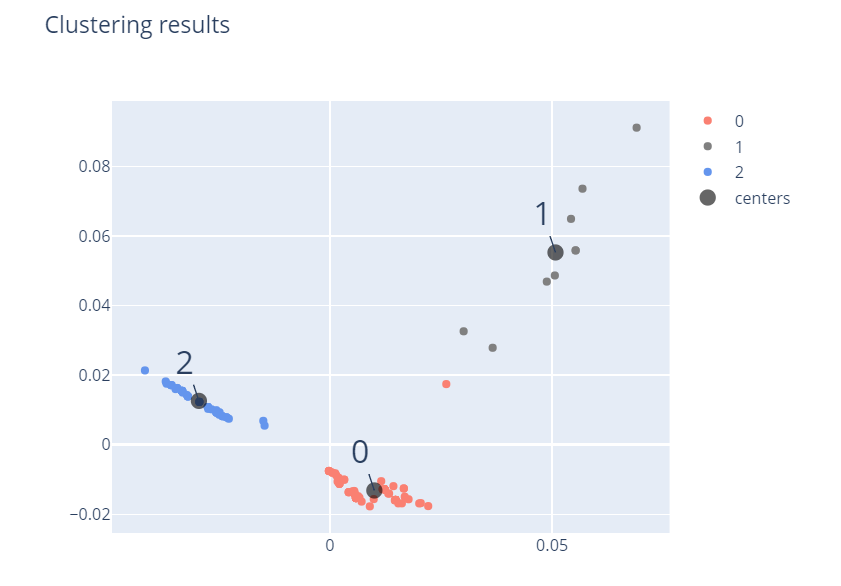

In [529]:
from sklearn.metrics import pairwise_distances_argmin_min

closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, custom_tfidf)

In [530]:
closest

array([68, 15, 43], dtype=int64)

In [531]:
for i in range(num_clusters):
    print("cluster {}".format(i+1))
    for w in set(corpus[closest[i]]):
        print(w)
    print()

cluster 1
расслабление после еды
воспаление (см. другие!)
жарко
при отсутствии симптомов - контроль давления
легкий голод
натощак - спазм желчных протоков (0,43) (см. другие)
спазм сосудов, боль (меньше 0,98)
у пожилых, очень сухая кожа - норма
стресс
повторить измерение, проверить сенсор!
не хватает воды
овуляция в точках щетовидки, яичников.
слабость, упадок сил. при повторении - обратить внимание
организм расслаблен
при повторе натощак - активация вирусов, серьезное подавление метаболизма, обратить внимание на состояние, воспаление слизистых
спазм

cluster 2
расслабление после еды
воспаление (см. другие!)
out of intervals
жарко
натощак - спазм желчных протоков (0,43) (см. другие)
спазм сосудов, боль (меньше 0,98)
печаль
стресс
повторить измерение, проверить сенсор!
овуляция в точках щетовидки, яичников.
часто у курильщиков
слабость, упадок сил. при повторении - обратить внимание
легкий голод
спазм

cluster 3
расслабление после еды
воспаление (см. другие!)
повторить измерение; при по

In [97]:
from collections import Counter

Кластер 0

In [121]:
first_class_words = np.argmax(custom_tfidf_df[y_kmeans == 0].values, axis=1)
first_class_words

array([ 8, 17,  8, 17,  8,  8,  8,  8, 17, 17,  8,  8, 17,  8,  8, 17,  8,
       17,  8,  8, 17, 17,  8, 17, 17, 17, 17, 17,  8, 17,  8, 17,  8,  8,
        8,  8,  8,  8,  8, 15, 15,  8], dtype=int64)

In [122]:
b = Counter(first_class_words)
b.most_common(3)

[(8, 24), (17, 16), (15, 2)]

In [123]:
print(custom_tfidf_df.columns[b.most_common(3)[0][0]])
print(custom_tfidf_df.columns[b.most_common(3)[1][0]])
print(custom_tfidf_df.columns[b.most_common(3)[2][0]])

опасная нагрузка на сердце
расширение сосудов
при повторе натощак - активация вирусов, серьезное подавление метаболизма, обратить внимание на состояние, воспаление слизистых


In [136]:
first_class_indexes = custom_tfidf_df[y_kmeans == 0].index
first_class_texts = []
for i in first_class_indexes:
    first_class_texts.extend(paraphrased_corpus[i])
    
b = Counter(first_class_texts)
b.most_common(7)

[('спазм', 159),
 ('слабость, упадок сил. при повторении - обратить внимание', 156),
 ('стресс', 122),
 ('легкий голод', 92),
 ('организм расслаблен', 90),
 ('воспаление (см. другие!)', 73),
 ('расслабление после еды', 45)]

Кластер 1

In [125]:
second_class_words = np.argmax(custom_tfidf_df[y_kmeans == 1].values, axis=1)
second_class_words

array([ 0,  0,  0, 10,  0,  0,  0,  0, 10], dtype=int64)

In [126]:
b = Counter(second_class_words)
b.most_common(4)

[(0, 7), (10, 2)]

In [127]:
custom_tfidf_df.columns[b.most_common(2)[0][0]]

'out of intervals'

In [137]:
second_class_indexes = custom_tfidf_df[y_kmeans == 1].index
second_class_texts = []
for i in second_class_indexes:
    second_class_texts.extend(paraphrased_corpus[i])
    
b = Counter(second_class_texts)
b.most_common(7)

[('спазм', 25),
 ('слабость, упадок сил. при повторении - обратить внимание', 24),
 ('жарко', 22),
 ('повторить измерение, проверить сенсор!', 21),
 ('воспаление (см. другие!)', 20),
 ('спазм сосудов, боль (меньше 0,98)', 19),
 ('стресс', 15)]

Кластер 2

In [131]:
third_class_words = np.argmax(custom_tfidf_df[y_kmeans == 2].values, axis=1)
print(third_class_words)
b = Counter(third_class_words)
b.most_common(7)

[ 6 22  5 22 22 22  0 22 22 22  5  6 22 22 22 22  6 22  5 22 22  5  5  5
 22  5 22 22  5  6 22 22  5  5  6]


[(22, 19), (5, 10), (6, 5), (0, 1)]

In [95]:
print(custom_tfidf_df.columns[b.most_common(2)[0][0]])
print(custom_tfidf_df.columns[b.most_common(2)[1][0]])
print(custom_tfidf_df.columns[b.most_common(3)[2][0]])

спазм сосудов, артерии - гипоксия!
угнетение после стресса
не хватает воды


In [129]:
second_class_indexes = custom_tfidf_df[y_kmeans == 2].index
second_class_texts = []
for i in second_class_indexes:
    second_class_texts.extend(corpus[i])
    
b = Counter(second_class_texts)
b.most_common(7)

[('спазм', 167),
 ('слабость, упадок сил. при повторении - обратить внимание', 109),
 ('стресс', 99),
 ('организм расслаблен', 81),
 ('расслабление после еды', 43),
 ('легкий голод', 41),
 ('спазм сосудов, боль (меньше 0,98)', 26)]

In [548]:
cols = custom_tfidf_df.columns

In [557]:
point_texts = []
for i in range(129):
    point_text = cols[custom_tfidf[i].argmax()]
    point_texts.append(point_text)

In [558]:
len(point_texts)

129

In [559]:
clusters = pd.DataFrame(t.T, columns=['e0','e1'])
clusters['label'] = y_kmeans
clusters['text'] = point_texts

In [560]:
clusters

,e0,e1,label,text
0,0.002152,-0.011248,0,не хватает воды
1,0.005867,-0.015344,0,"у пожилых, очень сухая кожа - норма"
2,0.011870,-0.012791,0,"спазм сосудов, боль (меньше 0,98)"
3,-0.000216,-0.007549,0,"натощак - спазм желчных протоков (0,43) (см. д..."
4,-0.031936,0.013867,2,опасная нагрузка на сердце
...,...,...,...,...
124,0.014764,-0.015888,0,жарко
125,0.012297,-0.012797,0,жарко
126,0.014764,-0.015888,0,жарко
127,0.012297,-0.012797,0,жарко


In [ ]:
import plotly.express as px

fig = px.scatter(clusters, x="e0", y="e1", color="label", hover_data=['text'])
fig.update_layout(
    title="Clustering results",
    autosize=False,
    width=600,
    height=500
)
fig.show()

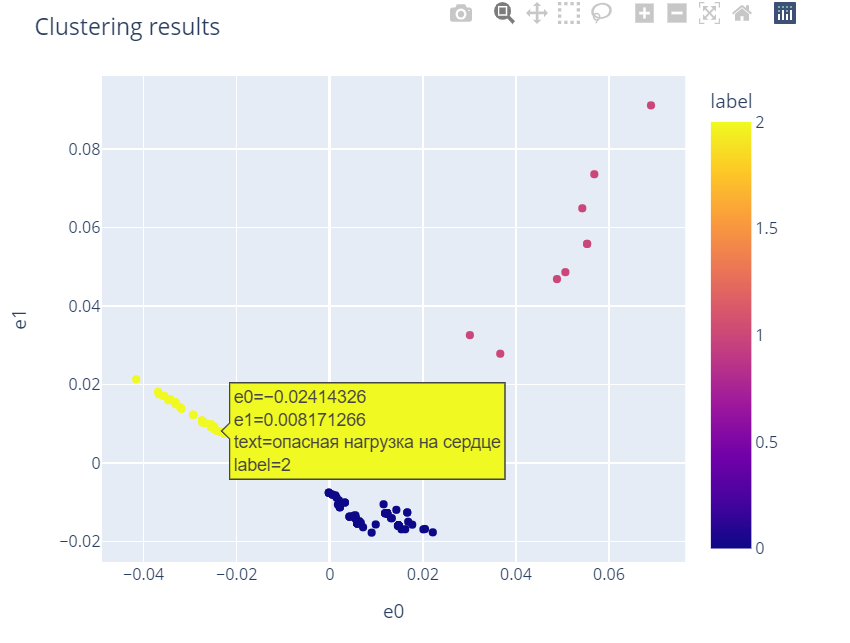

## Autoencoder

In [114]:
time=np.linspace(0,60,61)
tmin=int(time[0]+3)
tmax=int(tmin+len(time))

In [115]:
X = []
for f in data_files:
    meta, arr = get_arr(os.path.join('data', f))
    if arr.size > 0:
        X.append(list(arr[tmin:tmax]))
for f in os.listdir("data\delta_progress"):
    meta, arr = get_arr_from_covid_tfg(os.path.join('data\delta_progress', f))
    if arr.size > 0:
        X.append(list(arr[tmin:tmax]))
X = np.array(X)

In [116]:
X.shape

(129, 61)

In [568]:
y = clusters['label'].values

In [117]:
y = y_kmeans

In [118]:
from numpy import array
from tensorflow import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras import regularizers
# from keras.utils import plot_model
import matplotlib.pyplot as plt

from pyts.classification import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier

In [119]:
sequence = np.zeros((129,61))
for i in range(129):
    sequence[i] = X[i]/np.amax(X[i])

In [120]:
n_in=61
sequence = sequence.reshape((129, n_in, 1))

model = Sequential()
model.add(LSTM(32, activation='relu', input_shape=(n_in,1)))

model.add(RepeatVector(n_in))
model.add(LSTM(32, activation='relu', return_sequences=True))

model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')

# fit model
model.fit(sequence, sequence, epochs=300, verbose=0)

# demonstrate recreation
yhat = model.predict(sequence, verbose=0)

encoder = Model(inputs=model.inputs, outputs=model.layers[0].output)
#get the feature vector for the input sequence
inter = encoder.predict(sequence)
    

In [121]:
yhat[0,:,0].shape

(61,)

In [ ]:
import plotly.graph_objects as go
fig = go.Figure()
idx_x = 0
fig.add_trace(go.Scatter(x=np.arange(61), y=sequence[idx_x,:,0],
                    mode='lines',
                    name='original'))
fig.add_trace(go.Scatter(x=np.arange(61), y=yhat[idx_x,:,0],
                    mode='lines',
                    name='reconstruct'))

fig.update_layout(
    xaxis_title="time, s",
    yaxis_title="frequency (normalized)",
    title='Autoencoder reconstruction'
)
fig.show()

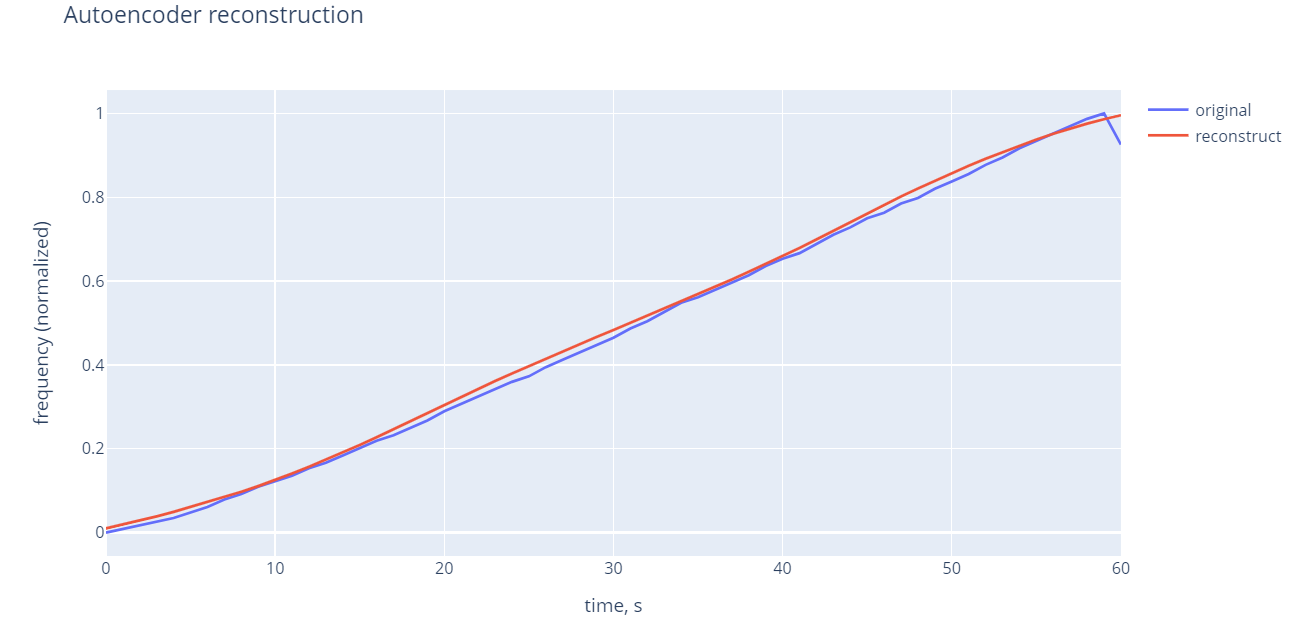

In [113]:
inter.shape

(129, 32)

In [114]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
results = pca.fit_transform(inter)

# results = reduced.transpose()
results.shape

(129, 2)

In [ ]:
results = pd.DataFrame(results, columns=['e0', 'e1'])
results['label'] = clusters['label'].astype(str)


In [467]:
colors = results['label'].copy()
colors.replace({'0': 'salmon', '1': 'gray', '2': 'cornflowerblue'}, inplace=True)

In [ ]:
fig = go.Figure()
r1=results[results.label=='0']
r2=results[results.label=='1']
r3=results[results.label=='2']
fig.add_trace(go.Scatter(x=r1['e0'], y=r1['e1'],
                mode = 'markers',
                marker=dict(
                    size=12,
                    color='salmon'),
                text=r1.index,
                name='cardiovascular'))
fig.add_trace(go.Scatter(x=r3['e0'], y=r3['e1'],
                mode = 'markers',
                marker=dict(
                    size=12,
                    color='cornflowerblue'),
                text=r3.index,
                name='stress'))
fig.add_trace(go.Scatter(x=r2['e0'], y=r2['e1'],
                mode = 'markers',
                marker=dict(
                    size=12,
                    color='gray'),
                text=r2.index,
                name='out'))
fig.update_layout(
    xaxis_title="first component",
    yaxis_title="second component",
    title='Autoencoder + PCA'
)
fig.show()

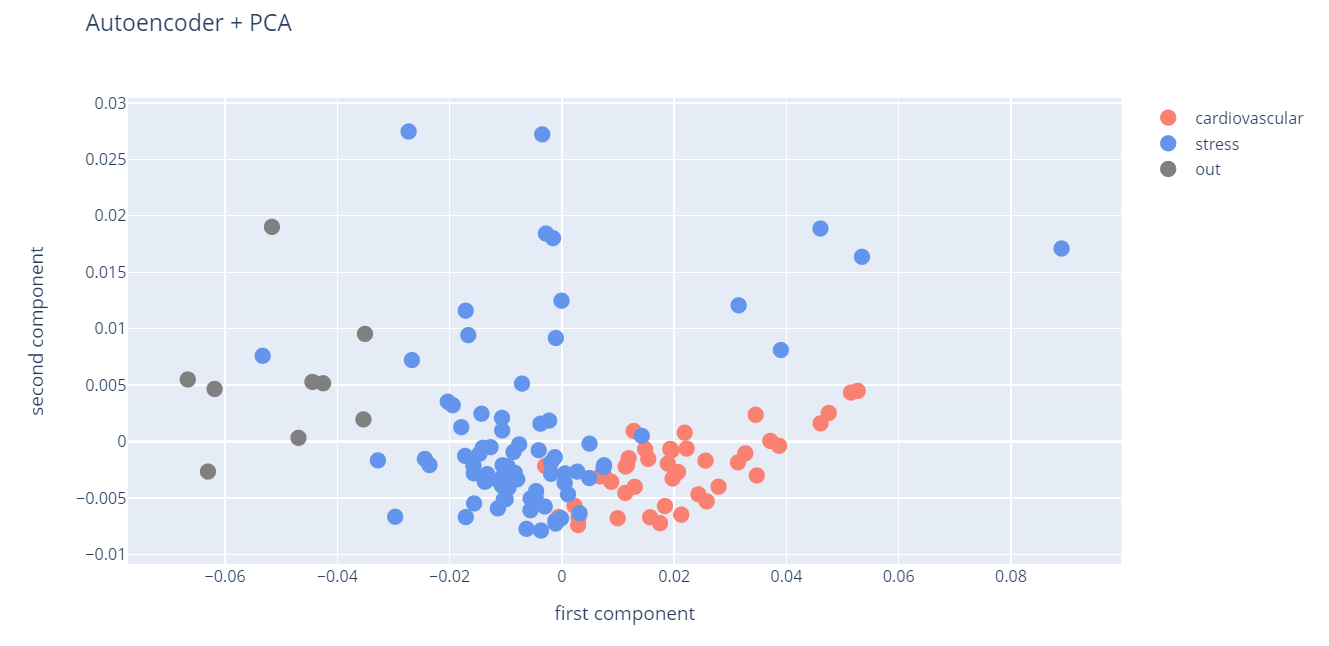

### Random Forest

In [487]:
clf = RandomForestClassifier()
cross_val_score(clf, results[['e0', 'e1']].values, results['label'].values, cv=5, scoring='f1_weighted')

array([0.87624683, 0.85054945, 0.8866005 , 0.92518797, 0.74571429])

In [498]:
np.mean(cross_val_score(clf, results[['e0', 'e1']].values, results['label'].values, cv=5, scoring='f1_weighted'))

0.8606441580629755

In [ ]:
import plotly.graph_objects as go
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

mesh_size = .002
margin = 0.01

# Load and split data
X = results[['e0', 'e1']].values
y = results['label'].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0)

# Create a mesh grid on which we will run our model
l_min, l_max = X[:,0].min() - margin, X[:,0].max() + margin
w_min, w_max = X[:,1].min() - margin, X[:,1].max() + margin
lrange = np.arange(l_min, l_max, mesh_size)
wrange = np.arange(w_min, w_max, mesh_size)
ll, ww = np.meshgrid(lrange, wrange)

# Create classifier, run predictions on grid
clf = RandomForestClassifier() 
clf.fit(X_train, y_train)
Z = clf.predict(np.c_[ll.ravel(), ww.ravel()])
Z = Z.reshape(ll.shape)
proba = clf.predict_proba(np.c_[ll.ravel(), ww.ravel()])
proba = proba.reshape(ll.shape + (3,))

# Compute the confidence, which is the difference
diff = proba.max(axis=-1) - (proba.sum(axis=-1) - proba.max(axis=-1))

fig = px.scatter(
    results, x='e0', y='e1',
    symbol='label',
    symbol_map={
        '0': 'square-dot',
        '1': 'circle-dot',
        '2': 'diamond-dot'},
)
fig.update_traces(
    marker_size=12, marker_line_width=1.5,
    marker_color="lightyellow"
)
fig.add_trace(
    go.Heatmap(
        x=lrange,
        y=wrange,
        z=diff,
        opacity=0.25,
        customdata=proba,
        colorscale='RdBu',
        hovertemplate=(
            'e0: %{x} <br>'
            'e1: %{y} <br>'
            'p(0): %{customdata[0]:.3f}<br>'
            'p(1): %{customdata[1]:.3f}<br>'
            'p(2): %{customdata[2]:.3f}<extra></extra>'
        )
    )
)
fig.update_layout(
    legend_orientation='h',
    title='Prediction Confidence on Test Split'
)
fig.show()

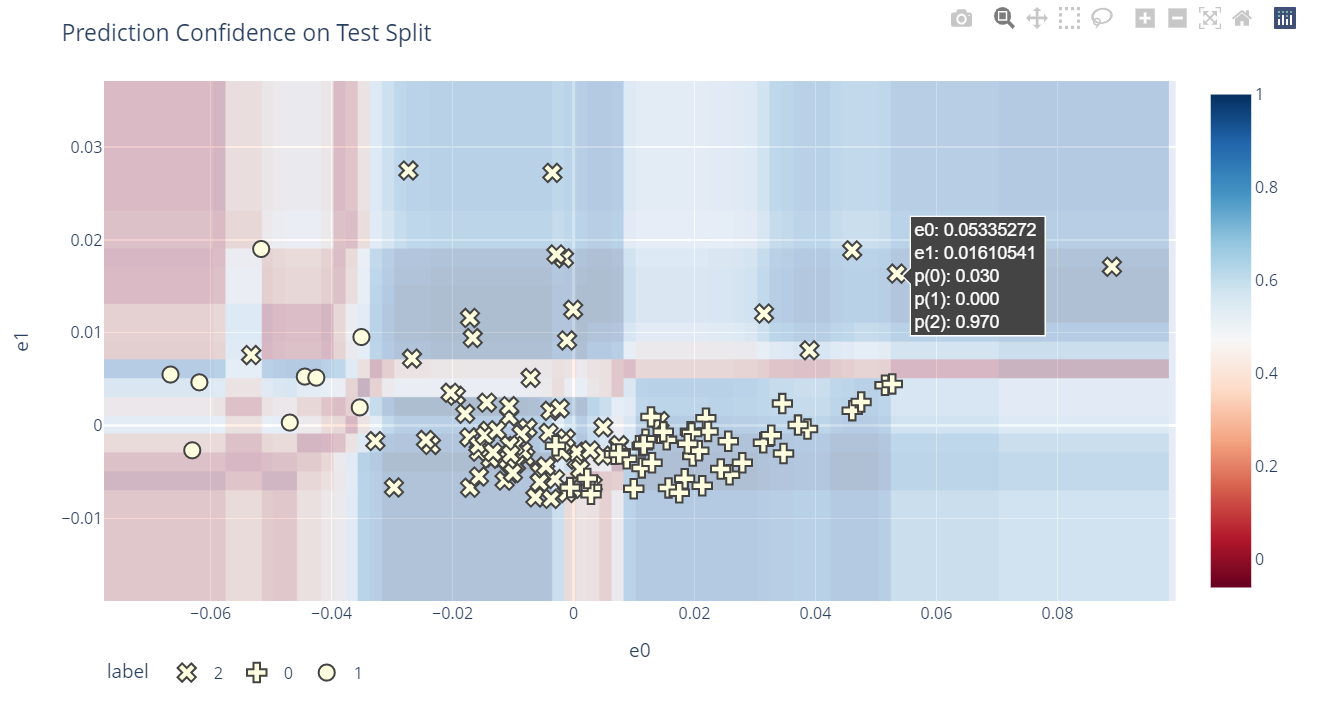

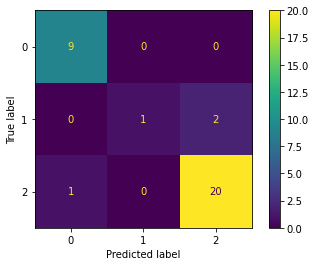

In [180]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()

### KNN

In [502]:
clf = KNeighborsClassifier(3, weights='distance')
cross_val_score(clf, results[['e0', 'e1']].values, results['label'].values, cv=5, scoring='f1_weighted')

array([0.87624683, 0.92478632, 0.92307692, 0.92518797, 0.72254083])

In [503]:
np.mean(cross_val_score(clf, results[['e0', 'e1']].values, results['label'].values, cv=5, scoring='f1_weighted'))

0.8743677765453558

In [ ]:
import plotly.graph_objects as go
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

mesh_size = .002
margin = 0.01

# Load and split data
X = results[['e0', 'e1']].values
y = results['label'].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0)

# Create a mesh grid on which we will run our model
l_min, l_max = X[:,0].min() - margin, X[:,0].max() + margin
w_min, w_max = X[:,1].min() - margin, X[:,1].max() + margin
lrange = np.arange(l_min, l_max, mesh_size)
wrange = np.arange(w_min, w_max, mesh_size)
ll, ww = np.meshgrid(lrange, wrange)

# Create classifier, run predictions on grid
clf = KNeighborsClassifier(3, weights='distance')
clf.fit(X_train, y_train)
Z = clf.predict(np.c_[ll.ravel(), ww.ravel()])
Z = Z.reshape(ll.shape)
proba = clf.predict_proba(np.c_[ll.ravel(), ww.ravel()])
proba = proba.reshape(ll.shape + (3,))

# Compute the confidence, which is the difference
diff = proba.max(axis=-1) - (proba.sum(axis=-1) - proba.max(axis=-1))

fig = px.scatter(
    results, x='e0', y='e1',
    symbol='label',
    symbol_map={
        '0': 'square-dot',
        '1': 'circle-dot',
        '2': 'diamond-dot'},
)
fig.update_traces(
    marker_size=12, marker_line_width=1.5,
    marker_color="lightyellow"
)
fig.add_trace(
    go.Heatmap(
        x=lrange,
        y=wrange,
        z=diff,
        opacity=0.25,
        customdata=proba,
        colorscale='RdBu',
        hovertemplate=(
            'e0: %{x} <br>'
            'e1: %{y} <br>'
            'p(0): %{customdata[0]:.3f}<br>'
            'p(1): %{customdata[1]:.3f}<br>'
            'p(2): %{customdata[2]:.3f}<extra></extra>'
        )
    )
)
fig.update_layout(
    legend_orientation='h',
    title='Prediction Confidence on Test Split'
)
fig.show()

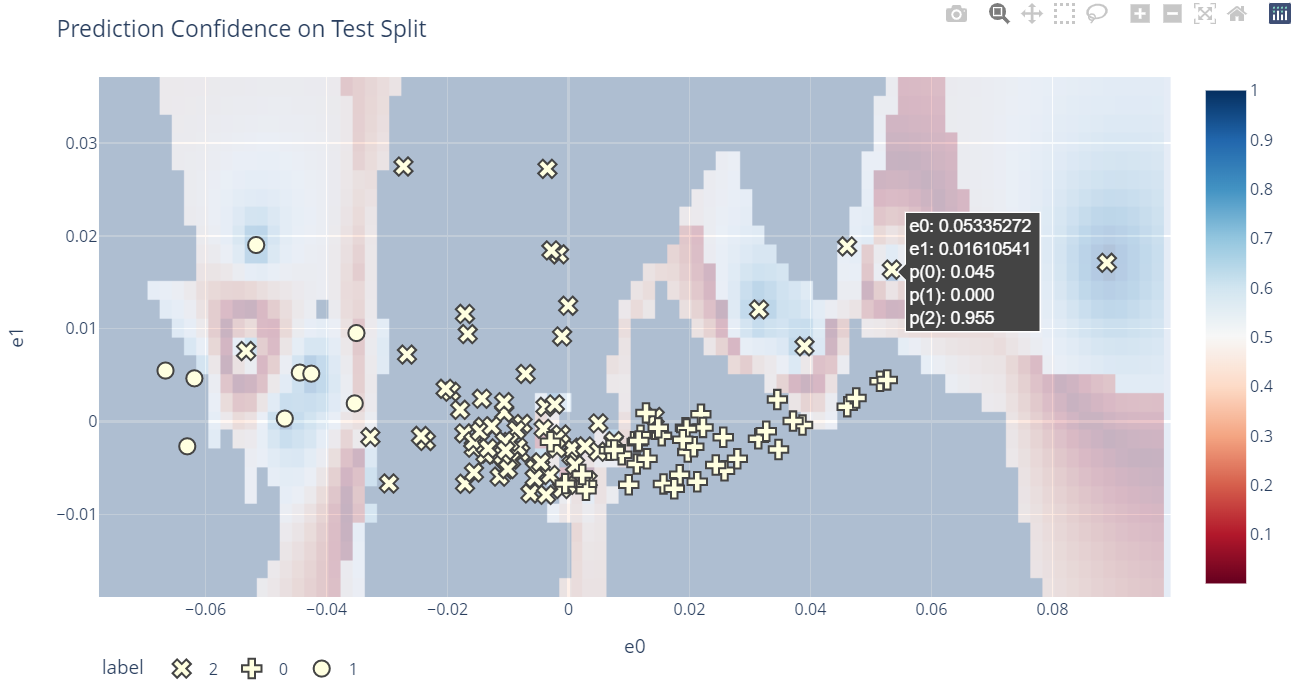

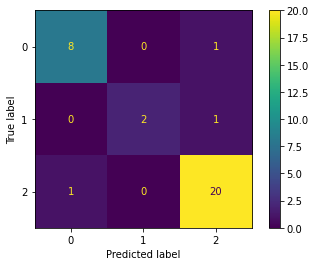

In [174]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()

### XGBoost

In [421]:
import xgboost as xgb
from xgboost import XGBClassifier

In [505]:
clf = XGBClassifier()
cross_val_score(clf, results[['e0', 'e1']].values, results['label'].astype(int).values, cv=5, scoring='f1_weighted')

array([0.87765568, 0.85054945, 0.84615385, 0.92518797, 0.95946869])

In [506]:
np.mean(cross_val_score(clf, results[['e0', 'e1']].values, results['label'].astype(int).values, cv=5, scoring='f1_weighted'))

0.8918031269971746

In [ ]:
import plotly.graph_objects as go
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

mesh_size = .002
margin = 0.01

# Load and split data
X = results[['e0', 'e1']].values
y = results['label'].astype(int).values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0)

# Create a mesh grid on which we will run our model
l_min, l_max = X[:,0].min() - margin, X[:,0].max() + margin
w_min, w_max = X[:,1].min() - margin, X[:,1].max() + margin
lrange = np.arange(l_min, l_max, mesh_size)
wrange = np.arange(w_min, w_max, mesh_size)
ll, ww = np.meshgrid(lrange, wrange)

# Create classifier, run predictions on grid
clf = XGBClassifier()
clf.fit(X_train, y_train)
Z = clf.predict(np.c_[ll.ravel(), ww.ravel()])
Z = Z.reshape(ll.shape)
proba = clf.predict_proba(np.c_[ll.ravel(), ww.ravel()])
proba = proba.reshape(ll.shape + (3,))

# Compute the confidence, which is the difference
diff = proba.max(axis=-1) - (proba.sum(axis=-1) - proba.max(axis=-1))

fig = px.scatter(
    results, x='e0', y='e1',
    symbol='label',
    symbol_map={
        '0': 'square-dot',
        '1': 'circle-dot',
        '2': 'diamond-dot'},
)
fig.update_traces(
    marker_size=12, marker_line_width=1.5,
    marker_color="lightyellow"
)
fig.add_trace(
    go.Heatmap(
        x=lrange,
        y=wrange,
        z=diff,
        opacity=0.25,
        customdata=proba,
        colorscale='RdBu',
        hovertemplate=(
            'e0: %{x} <br>'
            'e1: %{y} <br>'
            'p(0): %{customdata[0]:.3f}<br>'
            'p(1): %{customdata[1]:.3f}<br>'
            'p(2): %{customdata[2]:.3f}<extra></extra>'
        )
    )
)
fig.update_layout(
    legend_orientation='h',
    title='Prediction Confidence on Test Split'
)
fig.show()

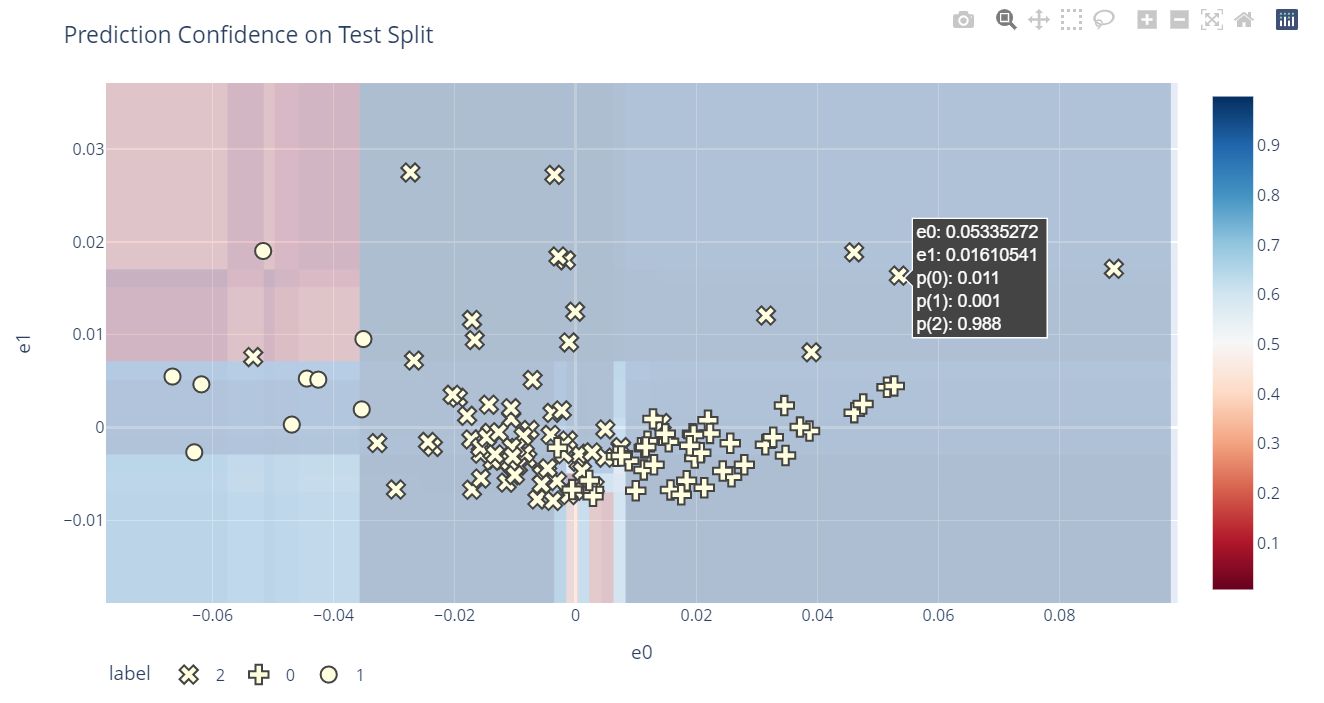

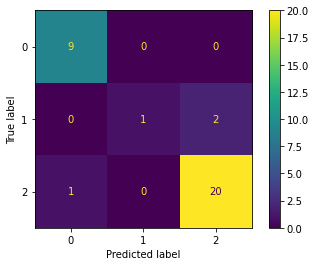

In [188]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()

In [191]:
results.to_csv('result_autoencoder_latent_32_pca.csv')

In [192]:
model.save('full_autoencoder_latent_32_pca')

INFO:tensorflow:Assets written to: full_autoencoder_latent_32_pca\assets


In [428]:
sequence.shape

(129, 61)

## t-SNE

In [208]:
from sklearn.manifold import TSNE
results = TSNE(n_components=2, learning_rate='auto',
               init='random').fit_transform(inter)
results.shape

(129, 2)

In [ ]:
results = pd.DataFrame(results, columns=['e0', 'e1'])
results['label'] = clusters['label']

In [ ]:
fig = go.Figure()
results['label'] = results['label'].astype(str)
r1=results[results.label=='0']
r2=results[results.label=='1']
r3=results[results.label=='2']
fig.add_trace(go.Scatter(x=r1['e0'], y=r1['e1'],
                mode = 'markers',
                marker=dict(
                    size=12,
                    color='salmon'),
                text=r1.index,
                name='cardiovascular'))
fig.add_trace(go.Scatter(x=r3['e0'], y=r3['e1'],
                mode = 'markers',
                marker=dict(
                    size=12,
                    color='cornflowerblue'),
                text=r3.index,
                name='stress'))
fig.add_trace(go.Scatter(x=r2['e0'], y=r2['e1'],
                mode = 'markers',
                marker=dict(
                    size=12,
                    color='gray'),
                text=r2.index,
                name='out'))

fig.update_layout(
    xaxis_title="first component",
    yaxis_title="second component",
    title='Autoencoder + t-SNE'
)
fig.show()


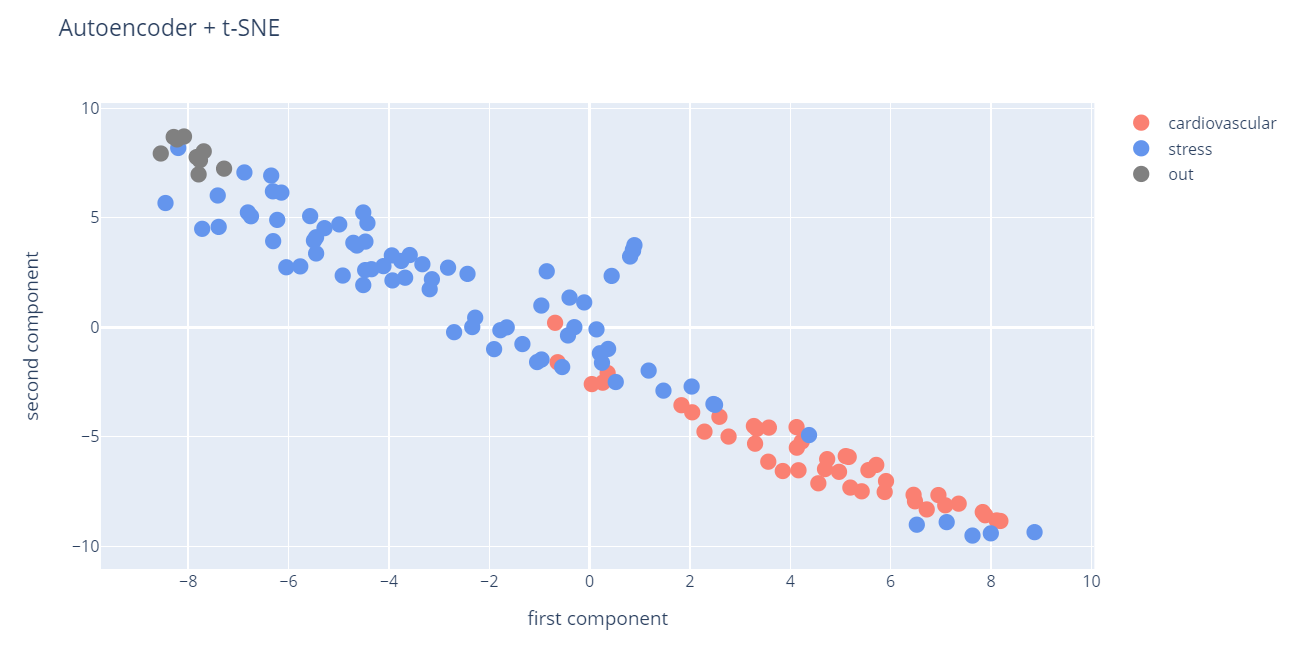

## Random Forest

In [594]:
clf = RandomForestClassifier()
cross_val_score(clf, results[['e0', 'e1']].values, results['label'].values, cv=5, scoring='f1_weighted')

array([0.91984486, 0.88775653, 0.8866005 , 0.92518797, 0.74571429])

In [595]:
np.mean(cross_val_score(clf, results[['e0', 'e1']].values, results['label'].values, cv=5, scoring='f1_weighted'))

0.8587615850360807

In [ ]:
import plotly.graph_objects as go
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

mesh_size = .02
margin = 1

# Load and split data
X = results[['e0', 'e1']].values
y = results['label'].astype(int).values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0)

# Create a mesh grid on which we will run our model
l_min, l_max = X[:,0].min() - margin, X[:,0].max() + margin
w_min, w_max = X[:,1].min() - margin, X[:,1].max() + margin
lrange = np.arange(l_min, l_max, mesh_size)
wrange = np.arange(w_min, w_max, mesh_size)
ll, ww = np.meshgrid(lrange, wrange)

# Create classifier, run predictions on grid
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
Z = clf.predict(np.c_[ll.ravel(), ww.ravel()])
Z = Z.reshape(ll.shape)
proba = clf.predict_proba(np.c_[ll.ravel(), ww.ravel()])
proba = proba.reshape(ll.shape + (3,))

# Compute the confidence, which is the difference
diff = proba.max(axis=-1) - (proba.sum(axis=-1) - proba.max(axis=-1))

fig = px.scatter(
    results, x='e0', y='e1',
    symbol='label',
    symbol_map={
        '0': 'square-dot',
        '1': 'circle-dot',
        '2': 'diamond-dot'},
)
fig.update_traces(
    marker_size=12, marker_line_width=1.5,
    marker_color="lightyellow"
)
fig.add_trace(
    go.Heatmap(
        x=lrange,
        y=wrange,
        z=diff,
        opacity=0.25,
        customdata=proba,
        colorscale='RdBu',
        hovertemplate=(
            'e0: %{x} <br>'
            'e1: %{y} <br>'
            'p(0): %{customdata[0]:.3f}<br>'
            'p(1): %{customdata[1]:.3f}<br>'
            'p(2): %{customdata[2]:.3f}<extra></extra>'
        )
    )
)
fig.update_layout(
    legend_orientation='h',
    title='Prediction Confidence on Test Split'
)
fig.show()

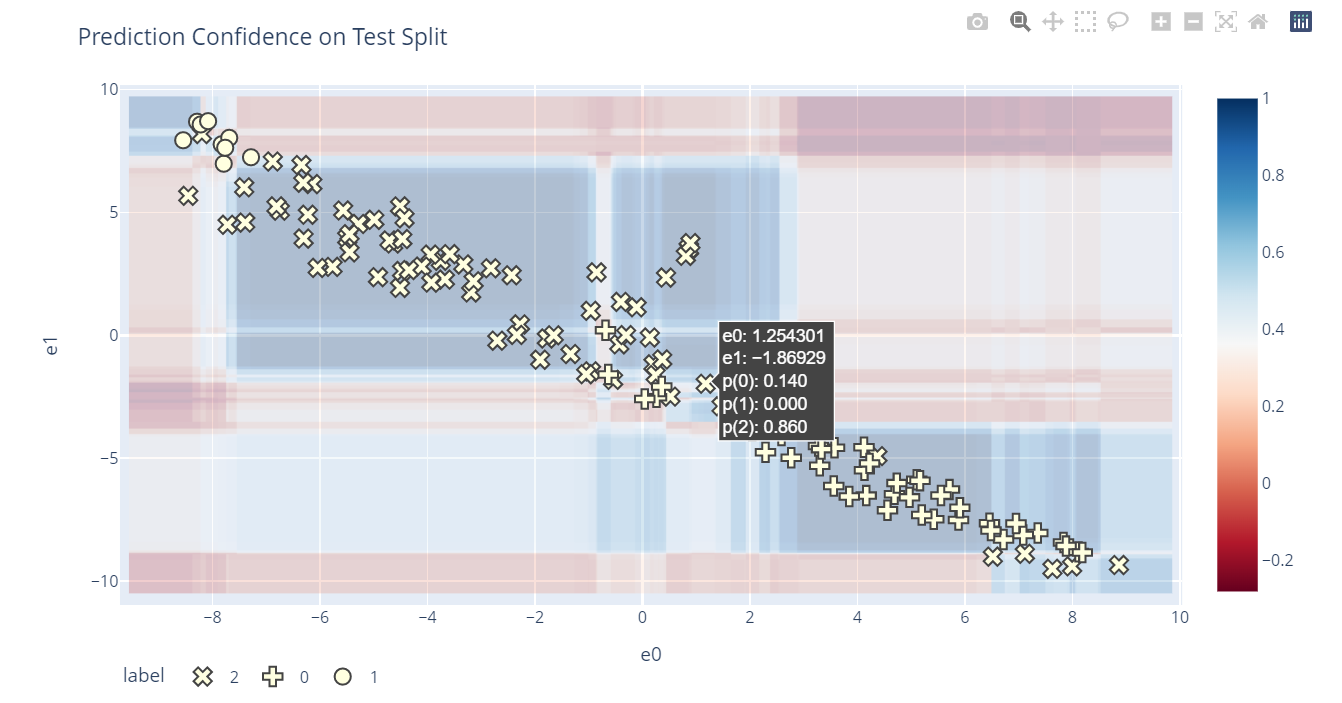

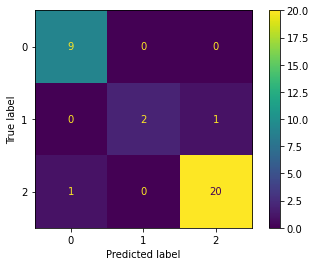

In [599]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()

## XGBoost

In [525]:
clf = XGBClassifier()
cross_val_score(clf, results[['e0', 'e1']].values, results['label'].astype(int).values, cv=5, scoring='f1_weighted')

array([0.91984486, 0.91779789, 0.85384615, 0.92518797, 0.74571429])

In [526]:
np.mean(cross_val_score(clf, results[['e0', 'e1']].values, results['label'].astype(int).values, cv=5, scoring='f1_weighted'))

0.8724782317785413

In [ ]:
import plotly.graph_objects as go
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

mesh_size = .02
margin = 1

# Load and split data
X = results[['e0', 'e1']].values
y = results['label'].astype(int).values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0)

# Create a mesh grid on which we will run our model
l_min, l_max = X[:,0].min() - margin, X[:,0].max() + margin
w_min, w_max = X[:,1].min() - margin, X[:,1].max() + margin
lrange = np.arange(l_min, l_max, mesh_size)
wrange = np.arange(w_min, w_max, mesh_size)
ll, ww = np.meshgrid(lrange, wrange)

# Create classifier, run predictions on grid
clf = XGBClassifier()
clf.fit(X_train, y_train)
Z = clf.predict(np.c_[ll.ravel(), ww.ravel()])
Z = Z.reshape(ll.shape)
proba = clf.predict_proba(np.c_[ll.ravel(), ww.ravel()])
proba = proba.reshape(ll.shape + (3,))

# Compute the confidence, which is the difference
diff = proba.max(axis=-1) - (proba.sum(axis=-1) - proba.max(axis=-1))

fig = px.scatter(
    results, x='e0', y='e1',
    symbol='label',
    symbol_map={
        '0': 'square-dot',
        '1': 'circle-dot',
        '2': 'diamond-dot'},
)
fig.update_traces(
    marker_size=12, marker_line_width=1.5,
    marker_color="lightyellow"
)
fig.add_trace(
    go.Heatmap(
        x=lrange,
        y=wrange,
        z=diff,
        opacity=0.25,
        customdata=proba,
        colorscale='RdBu',
        hovertemplate=(
            'e0: %{x} <br>'
            'e1: %{y} <br>'
            'p(0): %{customdata[0]:.3f}<br>'
            'p(1): %{customdata[1]:.3f}<br>'
            'p(2): %{customdata[2]:.3f}<extra></extra>'
        )
    )
)
fig.update_layout(
    legend_orientation='h',
    title='Prediction Confidence on Test Split'
)
fig.show()

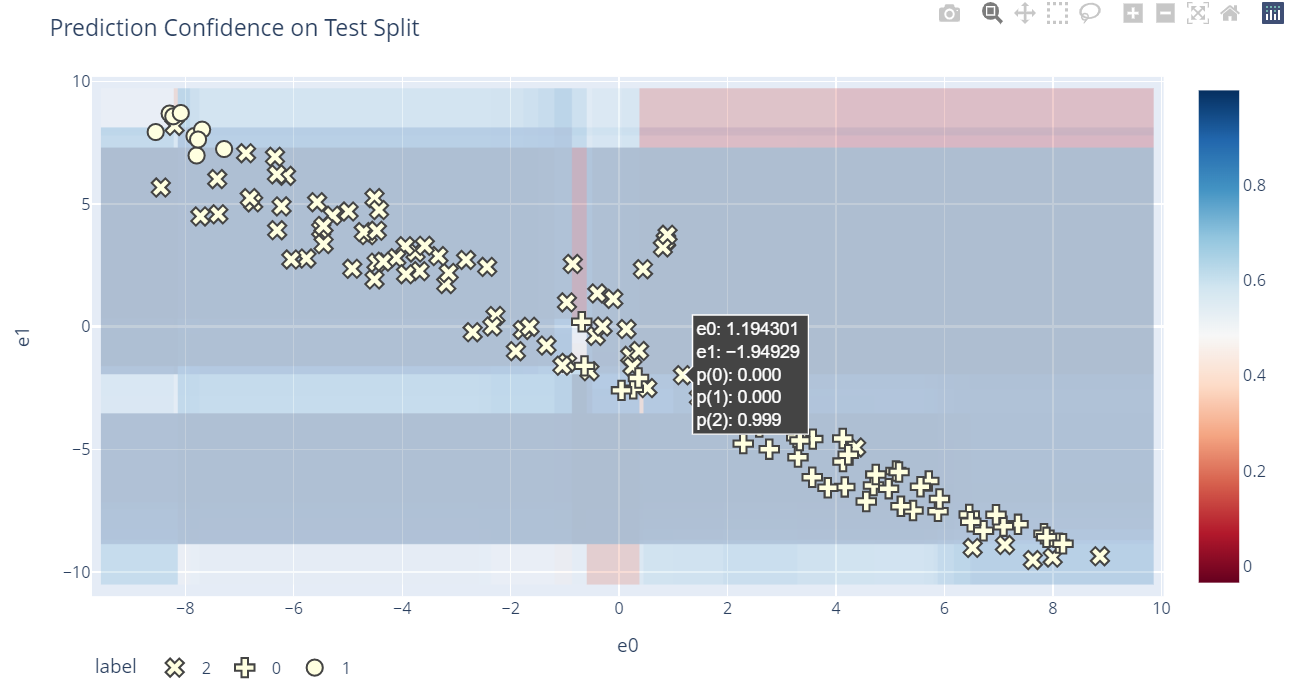

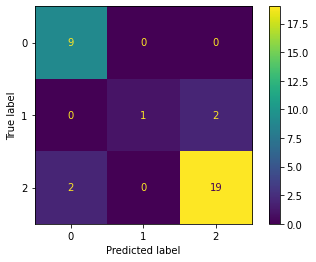

In [602]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()

## KNN

In [456]:
clf = KNeighborsClassifier(3, weights='distance')
cross_val_score(clf, results[['e0', 'e1']].values, results['label'].values, cv=5, scoring='f1_weighted')

array([0.88251748, 1.        , 0.8866005 , 0.92518797, 0.72254083])

In [459]:
np.mean(cross_val_score(clf, results[['e0', 'e1']].values, results['label'].values, cv=5, scoring='f1_weighted'))

0.883369356

In [ ]:
import plotly.graph_objects as go
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

mesh_size = .02
margin = 1

# Load and split data
X = results[['e0', 'e1']].values
y = results['label'].astype(int).values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0)

# Create a mesh grid on which we will run our model
l_min, l_max = X[:,0].min() - margin, X[:,0].max() + margin
w_min, w_max = X[:,1].min() - margin, X[:,1].max() + margin
lrange = np.arange(l_min, l_max, mesh_size)
wrange = np.arange(w_min, w_max, mesh_size)
ll, ww = np.meshgrid(lrange, wrange)

# Create classifier, run predictions on grid
clf = KNeighborsClassifier(3, weights='distance')
clf.fit(X_train, y_train)
Z = clf.predict(np.c_[ll.ravel(), ww.ravel()])
Z = Z.reshape(ll.shape)
proba = clf.predict_proba(np.c_[ll.ravel(), ww.ravel()])
proba = proba.reshape(ll.shape + (3,))

# Compute the confidence, which is the difference
diff = proba.max(axis=-1) - (proba.sum(axis=-1) - proba.max(axis=-1))

fig = px.scatter(
    results, x='e0', y='e1',
    symbol='label',
    symbol_map={
        '0': 'square-dot',
        '1': 'circle-dot',
        '2': 'diamond-dot'},
)
fig.update_traces(
    marker_size=12, marker_line_width=1.5,
    marker_color="lightyellow"
)
fig.add_trace(
    go.Heatmap(
        x=lrange,
        y=wrange,
        z=diff,
        opacity=0.25,
        customdata=proba,
        colorscale='RdBu',
        hovertemplate=(
            'e0: %{x} <br>'
            'e1: %{y} <br>'
            'p(0): %{customdata[0]:.3f}<br>'
            'p(1): %{customdata[1]:.3f}<br>'
            'p(2): %{customdata[2]:.3f}<extra></extra>'
        )
    )
)
fig.update_layout(
    legend_orientation='h',
    title='Prediction Confidence on Test Split'
)
fig.show()

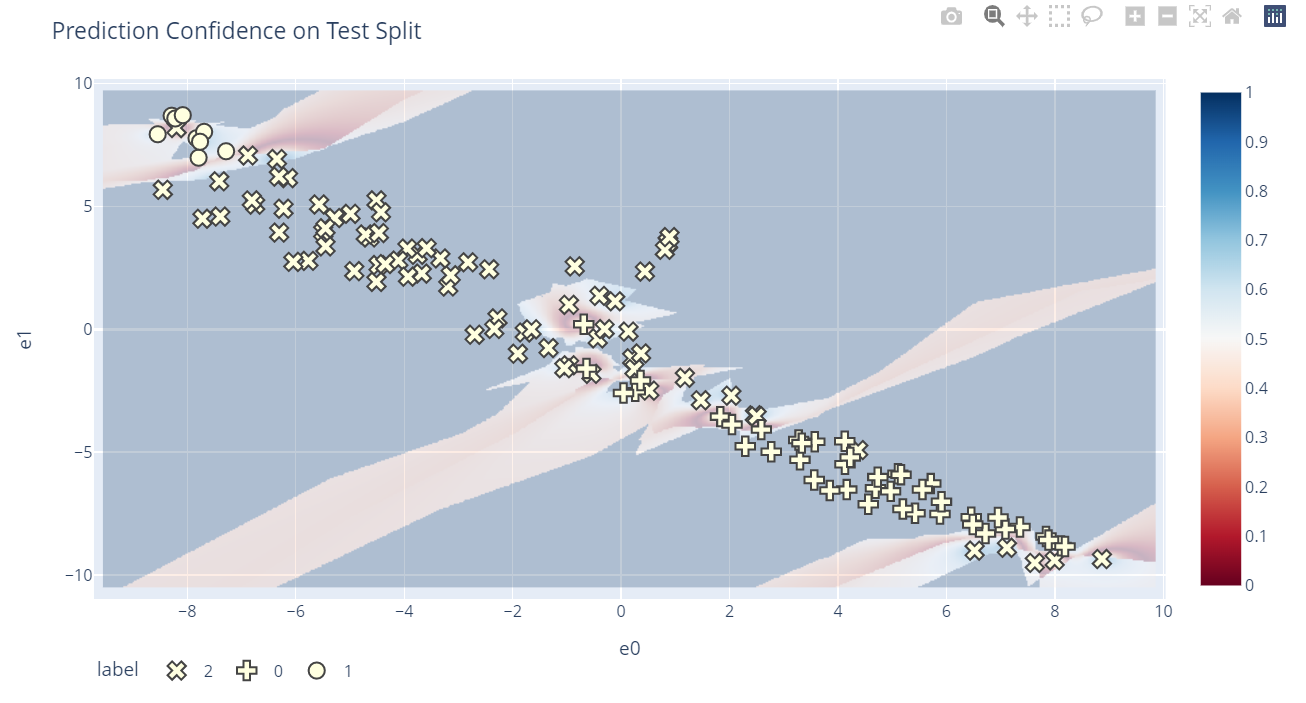

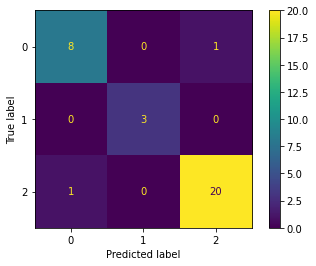

In [604]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()

In [221]:
results.to_csv('result_autoencoder_latent_32_tsne.csv')

## Autoencoder # latent

In [423]:
import random
np.random.seed(11)
sequence_noisy = sequence.copy()
for m in range(sequence.shape[0]):
    noise = np.array([random.gauss(0.03, 0.03) for i in range(sequence.shape[1])]).reshape(sequence.shape[1:])
    sequence_noisy[m] += noise

In [424]:
sequence_noisy.shape

(129, 61, 1)

In [431]:
import tensorflow as tf

In [479]:
def contractive_loss(autoencoder, y_true, y_pred):
    lam = 1e-6
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    
    w = autoencoder.get_layer('latent').get_weights()[0]
    b = autoencoder.get_layer('latent').get_weights()[2]
    pre_activation = tf.matmul(autoencoder.get_layer('latent').input, w) + b
    indicator = tf.nn.relu(tf.sign(pre_activation))
    w_s = tf.square(w)
    w_ = tf.transpose(tf.reduce_sum(w_s, axis=0, keepdims=True))
    batch_jacobian_vec = tf.matmul(indicator, w_)
    jacobian = tf.reduce_mean(batch_jacobian_vec)

    return mse + lam * jacobian

In [480]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(n_in,1), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=True))
model.add(LSTM(2, activation='linear', name='latent'))

model.add(RepeatVector(n_in))
model.add(LSTM(2, activation='linear', return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))

model.add_loss(contractive_loss(model, model.input, model.output))

model.compile(optimizer='adam')
# fit model
model.fit(sequence, sequence, epochs=300, verbose=0)

# demonstrate recreation
yhat = model.predict(sequence, verbose=0)


encoder = Model(inputs=model.inputs, outputs=model.get_layer('latent').output)
#get the feature vector for the input sequence
inter = encoder.predict(sequence)

In [ ]:
import plotly.graph_objects as go
fig = go.Figure()
idx_x = 1
fig.add_trace(go.Scatter(x=np.arange(61), y=sequence[idx_x,:,0],
                    mode='lines',
                    name='original'))
fig.add_trace(go.Scatter(x=np.arange(61), y=yhat[idx_x,:,0],
                    mode='lines',
                    name='reconstruct'))

fig.show()

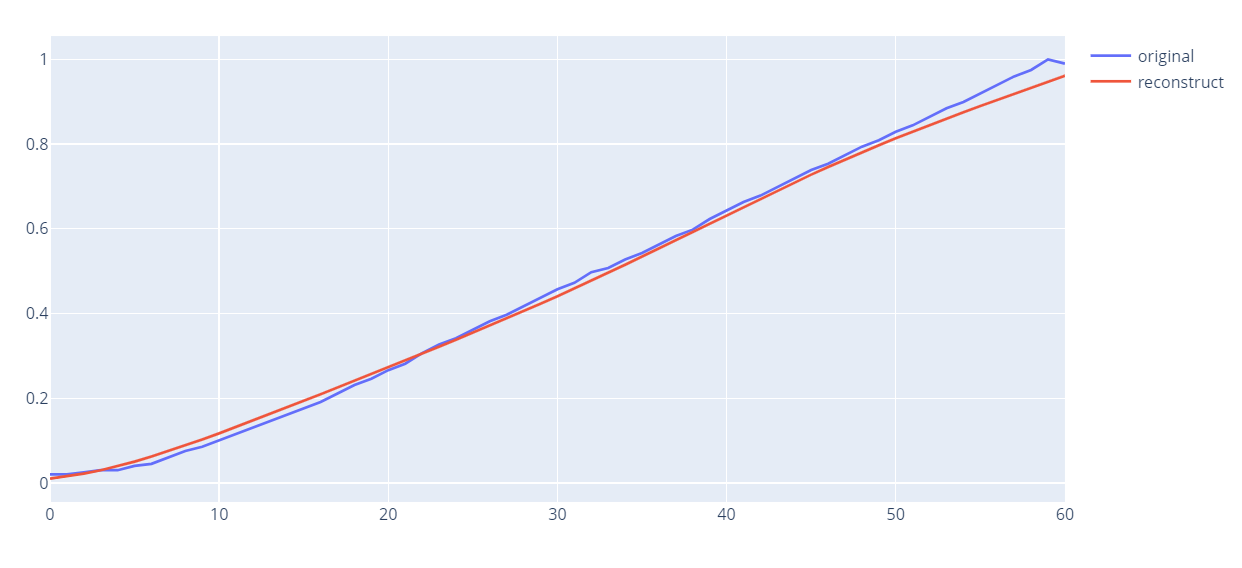

In [ ]:
results = pd.DataFrame(inter, columns=['e0', 'e1'])
results['label'] = clusters['label'].astype(str)

fig = px.scatter(results, x="e0", y="e1", color="label")
fig.show()

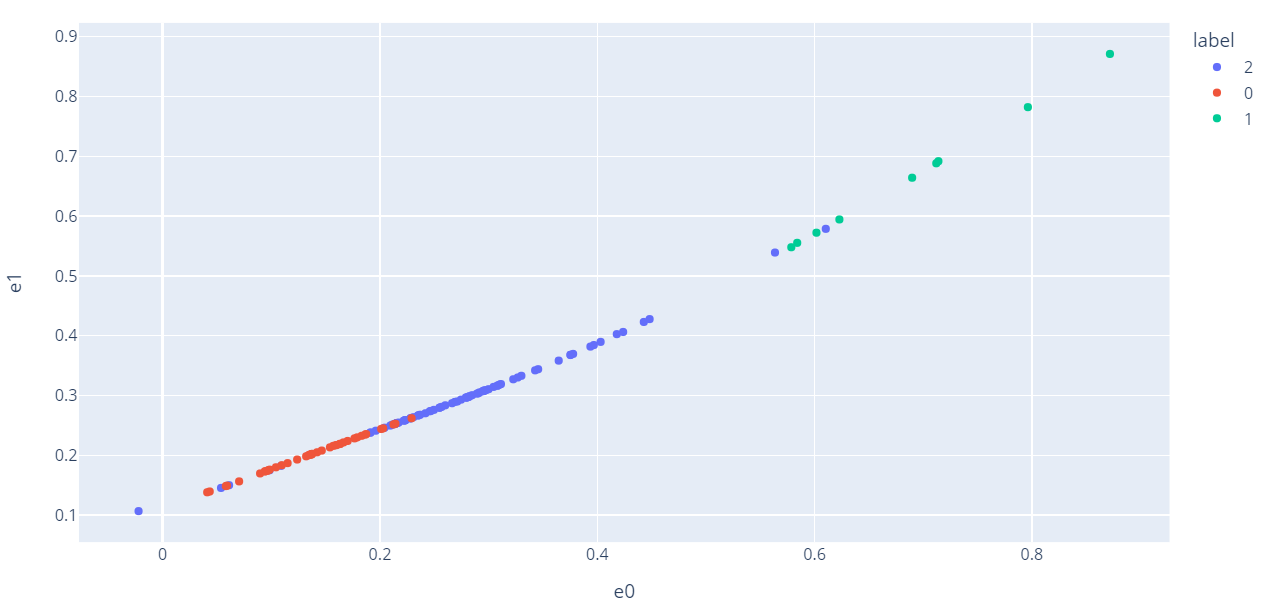

In [483]:
clf = RandomForestClassifier()
cross_val_score(clf, results[['e0', 'e1']].values, results['label'].values, cv=5, scoring='f1_weighted')

array([0.77697978, 0.88061759, 0.7985348 , 0.8128655 , 0.8031746 ])

In [484]:
np.mean(cross_val_score(clf, results[['e0', 'e1']].values, results['label'].values, cv=5, scoring='f1_weighted'))

0.8077564465340357

In [ ]:
mesh_size = .002
margin = 0.01

# Load and split data
X = results[['e0', 'e1']].values
y = results['label'].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0)

# Create a mesh grid on which we will run our model
l_min, l_max = X[:,0].min() - margin, X[:,0].max() + margin
w_min, w_max = X[:,1].min() - margin, X[:,1].max() + margin
lrange = np.arange(l_min, l_max, mesh_size)
wrange = np.arange(w_min, w_max, mesh_size)
ll, ww = np.meshgrid(lrange, wrange)

# Create classifier, run predictions on grid
clf = RandomForestClassifier() 
clf.fit(X_train, y_train)
Z = clf.predict(np.c_[ll.ravel(), ww.ravel()])
Z = Z.reshape(ll.shape)
proba = clf.predict_proba(np.c_[ll.ravel(), ww.ravel()])
proba = proba.reshape(ll.shape + (3,))

# Compute the confidence, which is the difference
diff = proba.max(axis=-1) - (proba.sum(axis=-1) - proba.max(axis=-1))

fig = px.scatter(
    results, x='e0', y='e1',
    symbol='label',
    symbol_map={
        '0': 'square-dot',
        '1': 'circle-dot',
        '2': 'diamond-dot'},
)
fig.update_traces(
    marker_size=12, marker_line_width=1.5,
    marker_color="lightyellow"
)
fig.add_trace(
    go.Heatmap(
        x=lrange,
        y=wrange,
        z=diff,
        opacity=0.25,
        customdata=proba,
        colorscale='RdBu',
        hovertemplate=(
            'e0: %{x} <br>'
            'e1: %{y} <br>'
            'p(0): %{customdata[0]:.3f}<br>'
            'p(1): %{customdata[1]:.3f}<br>'
            'p(2): %{customdata[2]:.3f}<extra></extra>'
        )
    )
)
fig.update_layout(
    legend_orientation='h',
    title='Prediction Confidence on Test Split'
)
fig.show()

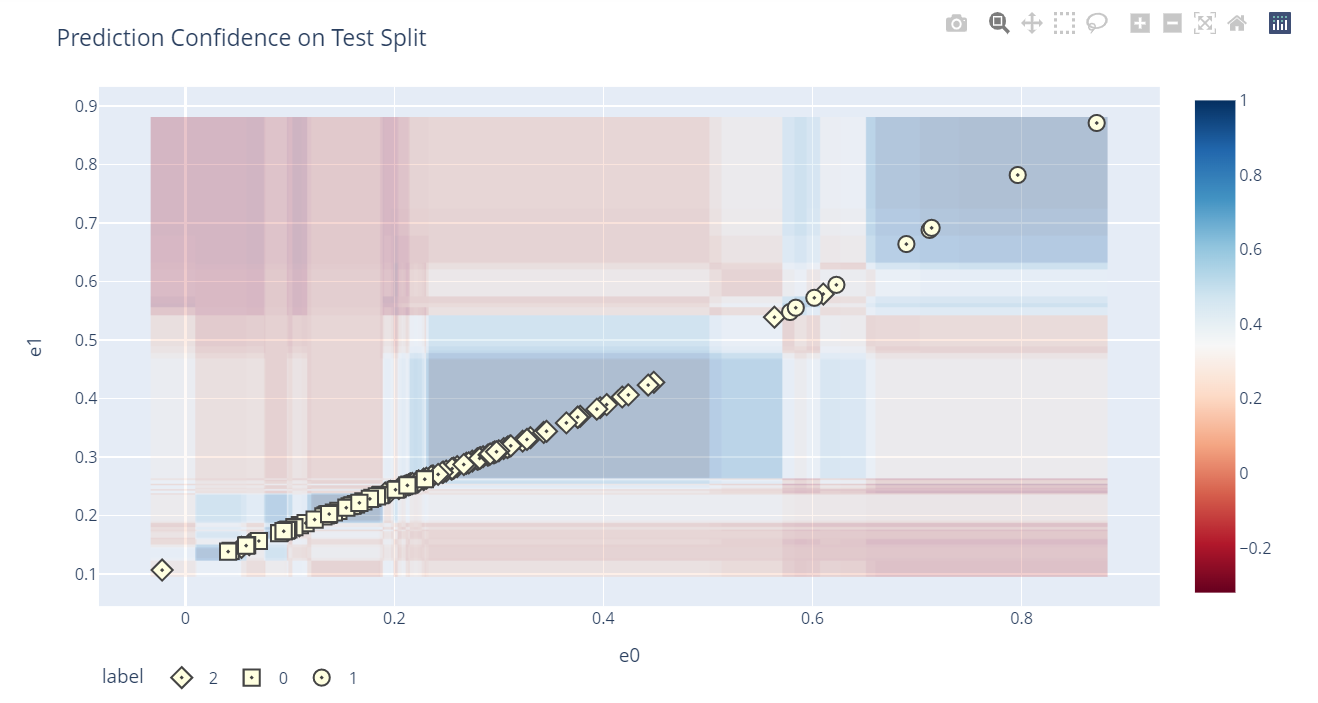

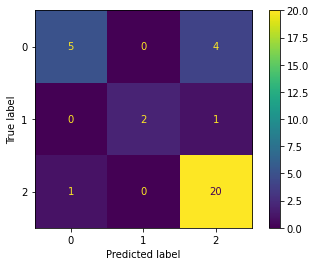

In [486]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()

In [487]:
clf = KNeighborsClassifier(3, weights='distance')
cross_val_score(clf, results[['e0', 'e1']].values, results['label'].values, cv=5, scoring='f1_weighted')

array([0.82905983, 0.96204934, 0.84042232, 0.85347985, 0.8031746 ])

In [488]:
np.mean(cross_val_score(clf, results[['e0', 'e1']].values, results['label'].values, cv=5, scoring='f1_weighted'))

0.8576371888705856

In [ ]:
mesh_size = .002
margin = 0.01

# Load and split data
X = results[['e0', 'e1']].values
y = results['label'].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0)

# Create a mesh grid on which we will run our model
l_min, l_max = X[:,0].min() - margin, X[:,0].max() + margin
w_min, w_max = X[:,1].min() - margin, X[:,1].max() + margin
lrange = np.arange(l_min, l_max, mesh_size)
wrange = np.arange(w_min, w_max, mesh_size)
ll, ww = np.meshgrid(lrange, wrange)

# Create classifier, run predictions on grid
clf = KNeighborsClassifier(3, weights='distance')
clf.fit(X_train, y_train)
Z = clf.predict(np.c_[ll.ravel(), ww.ravel()])
Z = Z.reshape(ll.shape)
proba = clf.predict_proba(np.c_[ll.ravel(), ww.ravel()])
proba = proba.reshape(ll.shape + (3,))

# Compute the confidence, which is the difference
diff = proba.max(axis=-1) - (proba.sum(axis=-1) - proba.max(axis=-1))

fig = px.scatter(
    results, x='e0', y='e1',
    symbol='label',
    symbol_map={
        '0': 'square-dot',
        '1': 'circle-dot',
        '2': 'diamond-dot'},
)
fig.update_traces(
    marker_size=12, marker_line_width=1.5,
    marker_color="lightyellow"
)
fig.add_trace(
    go.Heatmap(
        x=lrange,
        y=wrange,
        z=diff,
        opacity=0.25,
        customdata=proba,
        colorscale='RdBu',
        hovertemplate=(
            'e0: %{x} <br>'
            'e1: %{y} <br>'
            'p(0): %{customdata[0]:.3f}<br>'
            'p(1): %{customdata[1]:.3f}<br>'
            'p(2): %{customdata[2]:.3f}<extra></extra>'
        )
    )
)
fig.update_layout(
    legend_orientation='h',
    title='Prediction Confidence on Test Split'
)
fig.show()

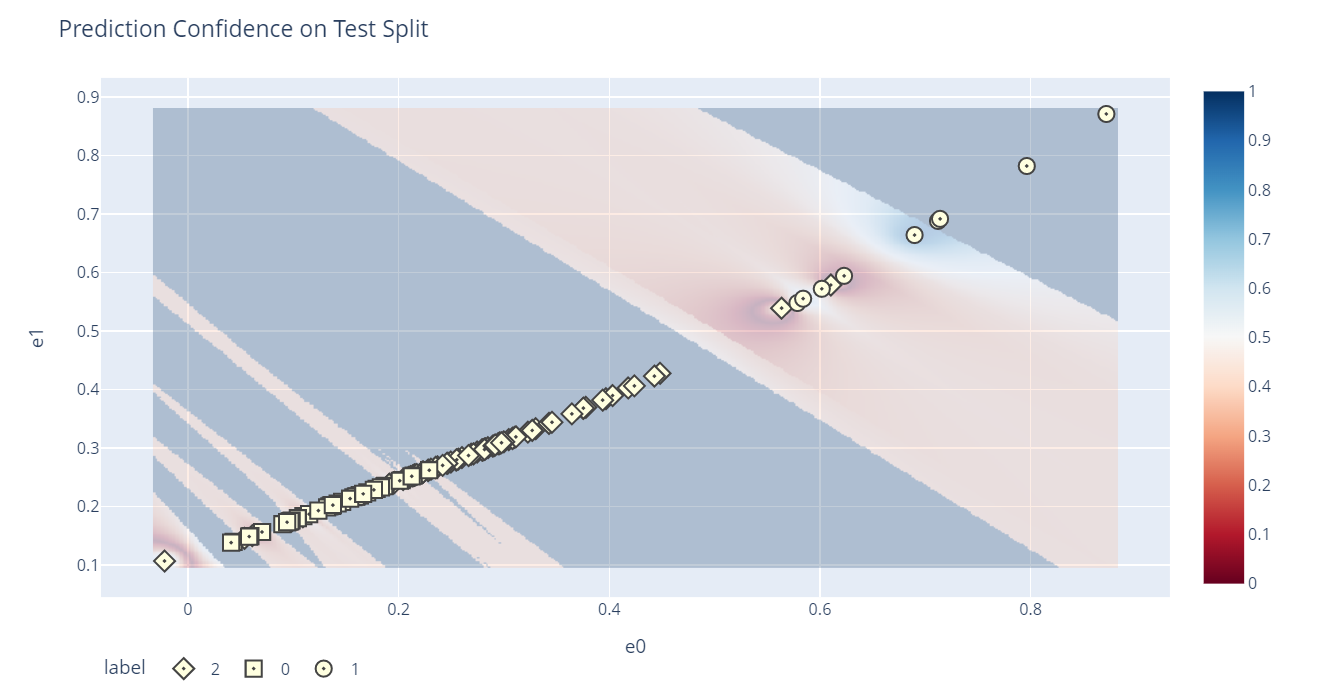

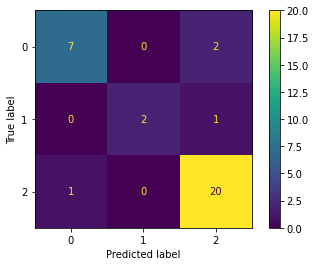

In [490]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()

In [494]:
clf = XGBClassifier()
cross_val_score(clf, results[['e0', 'e1']].values, results['label'].astype(int).values, cv=5, scoring='f1_weighted')

array([0.68777169, 0.92478632, 0.83968972, 0.8128655 , 0.8031746 ])

In [ ]:
mesh_size = .002
margin = 0.01

# Load and split data
X = results[['e0', 'e1']].values
y = results['label'].astype(int).values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0)

# Create a mesh grid on which we will run our model
l_min, l_max = X[:,0].min() - margin, X[:,0].max() + margin
w_min, w_max = X[:,1].min() - margin, X[:,1].max() + margin
lrange = np.arange(l_min, l_max, mesh_size)
wrange = np.arange(w_min, w_max, mesh_size)
ll, ww = np.meshgrid(lrange, wrange)

# Create classifier, run predictions on grid
clf = XGBClassifier()
clf.fit(X_train, y_train)
Z = clf.predict(np.c_[ll.ravel(), ww.ravel()])
Z = Z.reshape(ll.shape)
proba = clf.predict_proba(np.c_[ll.ravel(), ww.ravel()])
proba = proba.reshape(ll.shape + (3,))

# Compute the confidence, which is the difference
diff = proba.max(axis=-1) - (proba.sum(axis=-1) - proba.max(axis=-1))

fig = px.scatter(
    results, x='e0', y='e1',
    symbol='label',
    symbol_map={
        '0': 'square-dot',
        '1': 'circle-dot',
        '2': 'diamond-dot'},
)
fig.update_traces(
    marker_size=12, marker_line_width=1.5,
    marker_color="lightyellow"
)
fig.add_trace(
    go.Heatmap(
        x=lrange,
        y=wrange,
        z=diff,
        opacity=0.25,
        customdata=proba,
        colorscale='RdBu',
        hovertemplate=(
            'e0: %{x} <br>'
            'e1: %{y} <br>'
            'p(0): %{customdata[0]:.3f}<br>'
            'p(1): %{customdata[1]:.3f}<br>'
            'p(2): %{customdata[2]:.3f}<extra></extra>'
        )
    )
)
fig.update_layout(
    legend_orientation='h',
    title='Prediction Confidence on Test Split'
)
fig.show()

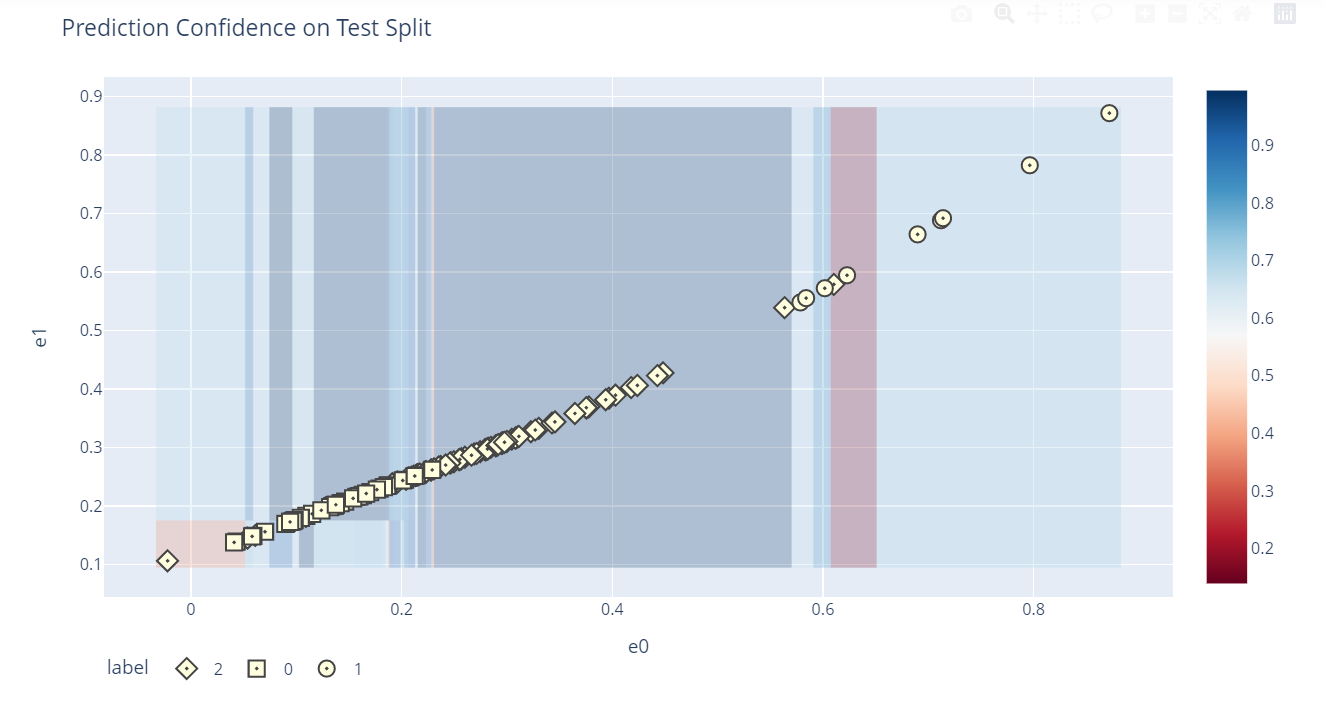

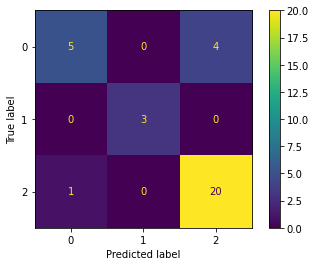

In [499]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()

In [512]:
clf = XGBClassifier(booster='dart', learning_rate=0.01)
cross_val_score(clf, results[['e0', 'e1']].values, results['label'].astype(int).values, cv=5, scoring='f1_weighted')

array([0.82905983, 0.92478632, 0.88251748, 0.8128655 , 0.76342857])

In [517]:
results.to_csv('result_autoencoder_latent_64_32_2_contractive.csv')